In [40]:
# GET LIBRARIES
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


In [55]:
# MAIN FUNCTIONS

def load_suite2p_outputs(base_directory, plane="plane0"):
    """Discover and load Suite2p outputs for every session under a subject-level directory."""
    file_dict = {
        'roi_fluorescence': '*F.npy',
        'neuropil_fluorescence': '*Fneu.npy',
        'cell_identifier': '*iscell.npy',
        'intermediate_outputs': '*ops.npy',
        'roi_traces': '*spks.npy',
        'roi_statistics': '*stat.npy'
    }
    base_path = Path(base_directory)
    if not base_path.exists():
        raise FileNotFoundError(f"Base directory not found: {base_directory}")
    subject_id = next((part for part in base_path.parts if part.startswith('sub-')), base_path.name)
    session_plane_paths = sorted(base_path.glob(f"ses-*/suite2p/{plane}"))
    if not session_plane_paths:
        raise FileNotFoundError(f"No sessions with {plane} found under {base_directory}")
    loaded_sessions = {}
    for plane_path in session_plane_paths:
        session_id = plane_path.parent.parent.name  # plane0 -> suite2p -> ses-*
        session_key = f"{subject_id}_{session_id}"
        session_data = {}
        for key, pattern in file_dict.items():
            matched_files = sorted(plane_path.glob(pattern))
            if not matched_files:
                raise FileNotFoundError(f"Missing file matching {pattern} in {plane_path}")
            session_data[key] = np.load(matched_files[0], allow_pickle=True)
        loaded_sessions[session_key] = session_data
    return loaded_sessions

def calculate_dff(raw, baseline):  # this will calculate the dff values for each roi
    dff_list = []
    for row in range(len(raw)):
        dff = ((raw[row] - baseline[row])/(baseline[row]))
        dff_list.append(dff)
    return dff_list

def calculate_baseline(raw_fluorescence, percentile):  # this will calculate the specified percentile along each roi's raw fluorescence
    percentile_list = []
    for row in raw_fluorescence:
        find_percentile = np.percentile(row, percentile, keepdims=True)
        percentile_list.append(find_percentile)
    return percentile_list

def calculate_average_roi(dff_data):
    """Return the frame-wise average ΔF/F across all ROIs."""
    dff_df = pd.DataFrame(dff_data).transpose()
    return pd.DataFrame(dff_df.mean(axis=1), columns=["Average_ROI"])

def normalise_subject_id(subject_id):
    return subject_id if subject_id.startswith("sub-") else f"sub-{subject_id}"

def normalise_session_id(session_id):
    return session_id if session_id.startswith("ses-") else f"ses-{session_id}"

def build_session_key(subject_id, session_id):
    subject_label = normalise_subject_id(subject_id)
    session_label = normalise_session_id(session_id)
    return subject_label, session_label, f"{subject_label}_{session_label}"

def plot_suite2p_rois(suite2p_sessions, session_key, roi_index=None, axsize=(18, 18)):
    """Plot colour-coded Suite2p ROIs for the requested session and optionally highlight a single ROI."""
    if session_key not in suite2p_sessions:
        raise KeyError(f"Session {session_key} not found in supplied Suite2p outputs.")
    session_data = suite2p_sessions[session_key]
    ops_obj = session_data['intermediate_outputs']
    output_ops = ops_obj.item() if isinstance(ops_obj, np.ndarray) else ops_obj
    if not isinstance(output_ops, dict):
        raise TypeError("Suite2p ops data is not a dictionary-like object.")
    if 'save_path' not in output_ops:
        raise KeyError("Suite2p ops dictionary does not contain 'save_path'.")
    save_path = Path(output_ops['save_path'])
    stat_path = save_path / 'stat.npy'
    iscell_path = save_path / 'iscell.npy'
    if not stat_path.exists() or not iscell_path.exists():
        raise FileNotFoundError(f"stat.npy or iscell.npy missing in {save_path}")
    stat_data = np.load(stat_path, allow_pickle=True)
    iscell_flags = np.load(iscell_path, allow_pickle=True)[:, 0].astype(int)
    Ly = output_ops.get('Ly')
    Lx = output_ops.get('Lx')
    if Ly is None or Lx is None:
        raise KeyError("Suite2p ops dictionary missing 'Ly' or 'Lx'.")
    n_cells = len(stat_data)
    colours = np.random.rand(n_cells)
    hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)
    for idx, stat in enumerate(stat_data):
        ypix = stat.get('ypix')
        xpix = stat.get('xpix')
        lam = stat.get('lam')
        if ypix is None or xpix is None or lam is None:
            continue
        lam_max = lam.max() if lam.max() != 0 else 1.0
        hsvs[iscell_flags[idx], ypix, xpix, 0] = colours[idx]
        hsvs[iscell_flags[idx], ypix, xpix, 1] = 1
        hsvs[iscell_flags[idx], ypix, xpix, 2] = lam / lam_max
    highlight_coords = None
    if roi_index is not None:
        if roi_index >= n_cells:
            raise IndexError(f"ROI index {roi_index} is out of range (total detected ROIs: {n_cells}).")
        stat = stat_data[roi_index]
        ypix = stat.get('ypix')
        xpix = stat.get('xpix')
        if ypix is not None and xpix is not None:
            highlight_coords = (xpix, ypix)
    from colorsys import hsv_to_rgb
    rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)
    plt.figure(figsize=axsize)
    plt.subplot(2, 1, 1)
    plt.imshow(output_ops['max_proj'], cmap='gray')
    plt.title("Registered Image, Max Projection")
    plt.subplot(2, 1, 2)
    plt.imshow(rgbs[1])
    plt.title("All Cell ROIs")
    if highlight_coords is not None:
        plt.scatter(highlight_coords[0], highlight_coords[1], s=10, facecolors='none', edgecolors='white', linewidths=0.7, label='Selected ROI')
        plt.legend(loc='upper right')
    plt.tight_layout()
    return rgbs

In [56]:
# LOAD DATA
DATA_ROOT = Path(r"C:\dev\ACUTEVIS\processed\func")
subject_id = "sub-ACUTEVIS06"
session_id = "ses-02"
roi_id = 0

subject_label, session_label, requested_session_key = build_session_key(subject_id, session_id)
suite2p_base_dir = DATA_ROOT / subject_label / "mov"

if not suite2p_base_dir.exists():
    raise FileNotFoundError(f"Base directory not found: {suite2p_base_dir}")

print(f"Configured subject: {subject_label}, session: {session_label}, ROI: {roi_id}")
print(f"Suite2p search path: {suite2p_base_dir}")

suite2p_sessions = load_suite2p_outputs(suite2p_base_dir)
available_sessions = list(suite2p_sessions.keys())
print(f"Loaded Suite2p outputs for {len(suite2p_sessions)} sessions: {available_sessions}")

if requested_session_key not in suite2p_sessions:
    raise KeyError(f"Requested session {requested_session_key} not found. Available sessions: {available_sessions}")

selected_session_key = requested_session_key
print(f"Active session set to {selected_session_key}")

Configured subject: sub-ACUTEVIS06, session: ses-02, ROI: 0
Suite2p search path: C:\dev\ACUTEVIS\processed\func\sub-ACUTEVIS06\mov
Loaded Suite2p outputs for 4 sessions: ['sub-ACUTEVIS06_ses-01', 'sub-ACUTEVIS06_ses-02', 'sub-ACUTEVIS06_ses-03', 'sub-ACUTEVIS06_ses-04']
Active session set to sub-ACUTEVIS06_ses-02


Generated RGB maps for ('sub-ACUTEVIS06', 'ses-02') with ROI 0 highlighted.


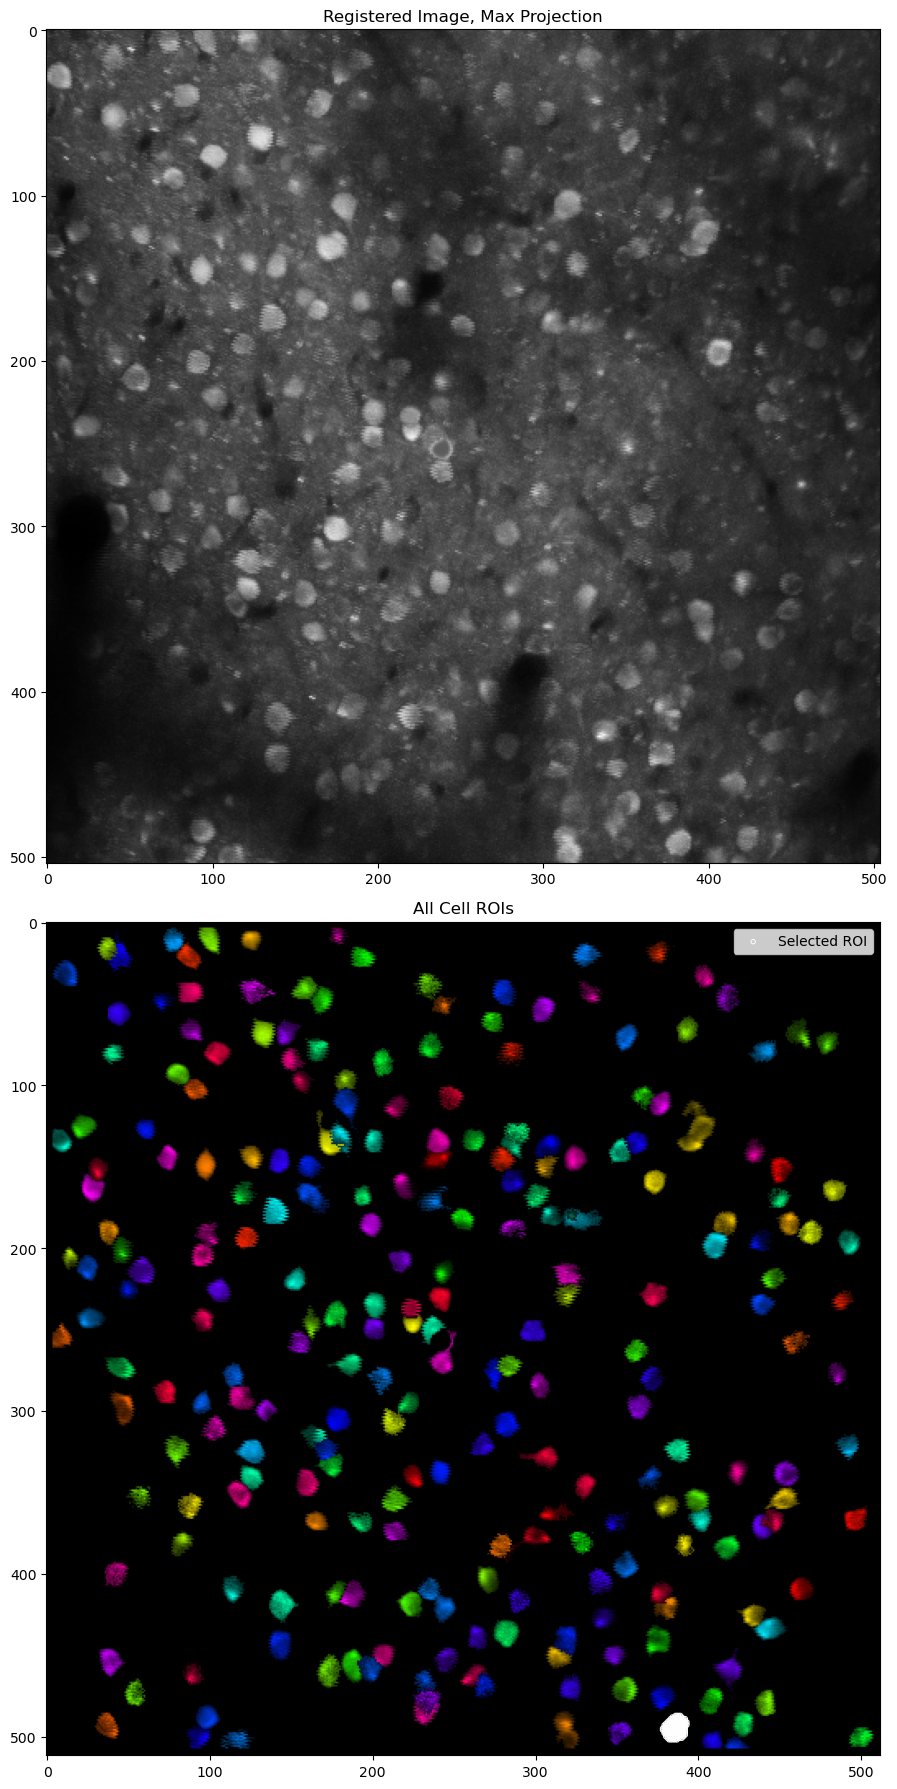

In [57]:
# VISUALIZE CELLS IN FOV
rgbs = plot_suite2p_rois(suite2p_sessions, selected_session_key, roi_id)
print(f"Generated RGB maps for {(subject_id, session_id)} with ROI {roi_id} highlighted.")

In [61]:
# PREPARE SESSION-LEVEL DATA

session_results = {}
for session_key, session_data in suite2p_sessions.items():
    true_cells_only = session_data['cell_identifier'][:, 0].astype(bool)
    filtered_roi = np.array(session_data['roi_fluorescence'][true_cells_only])
    filtered_neuropil = np.array(session_data['neuropil_fluorescence'][true_cells_only])
    neuropil_subtracted_roi = filtered_roi - (0.7 * filtered_neuropil)
    baseline_fluorescence = calculate_baseline(filtered_roi, percentile=10)
    roi_dff = calculate_dff(filtered_roi, baseline_fluorescence)
    average_df = calculate_average_roi(roi_dff)
    session_results[session_key] = {
        'true_cells_only': true_cells_only,
        'filtered_roi': filtered_roi,
        'filtered_neuropil': filtered_neuropil,
        'neuropil_subtracted_roi': neuropil_subtracted_roi,
        'baseline_fluorescence': baseline_fluorescence,
        'roi_dff': roi_dff,
        'average_df': average_df
    }
print(session_results.keys())

if selected_session_key not in session_results:
    raise KeyError(f"Selected session {selected_session_key} missing from prepared results.")

selected_results = session_results[selected_session_key]
total_rois = len(selected_results['roi_dff'])
selected_roi_index = roi_id
if selected_roi_index >= total_rois:
    raise IndexError(f"ROI index {selected_roi_index} is out of range for {selected_session_key} (total ROIs: {total_rois}).")

neuropil_subtracted_roi = selected_results['neuropil_subtracted_roi']
baseline_fluorescence = selected_results['baseline_fluorescence']
roi_dff = selected_results['roi_dff']

print(f"Selected session: {selected_session_key}")
print(f"Selected ROI index: {selected_roi_index} (total ROIs: {total_rois})")

C:\Users\sturt\AppData\Local\Temp\ipykernel_13492\3387814783.py:36: RuntimeWarning: invalid value encountered in divide
  dff = ((raw[row] - baseline[row])/(baseline[row]))


dict_keys(['sub-ACUTEVIS06_ses-01', 'sub-ACUTEVIS06_ses-02', 'sub-ACUTEVIS06_ses-03', 'sub-ACUTEVIS06_ses-04'])
Selected session: sub-ACUTEVIS06_ses-02
Selected ROI index: 0 (total ROIs: 247)


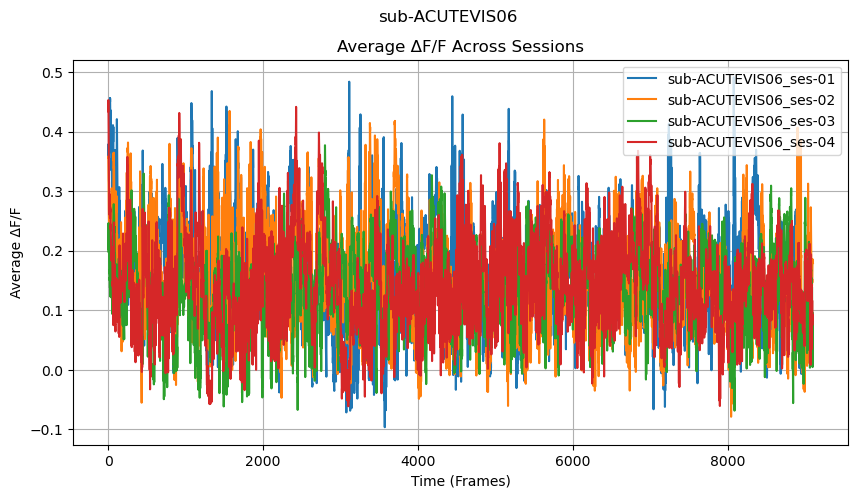

Frame-averaged ΔF/F per session:
                       Mean_Average_ROI
sub-ACUTEVIS06_ses-01          0.154649
sub-ACUTEVIS06_ses-02          0.151115
sub-ACUTEVIS06_ses-03          0.137672
sub-ACUTEVIS06_ses-04          0.144649


In [ ]:
# %% CALCULATE & PLOT AVERAGE DFF PER SESSION

average_dff_by_session = pd.DataFrame({
    session_key: results['average_df']['Average_ROI'] for session_key, results in session_results.items()
})

plt.figure(figsize=(10, 5))
for session_key in average_dff_by_session.columns:
    plt.plot(average_dff_by_session.index, average_dff_by_session[session_key], label=session_key)
plt.suptitle(subject_label)
plt.title("Average ΔF/F Across Sessions")
plt.xlabel("Time (Frames)")
plt.ylabel("Average ΔF/F")
plt.grid()
plt.legend()
plt.show()

session_mean_dff = average_dff_by_session.mean()
print("Frame-averaged ΔF/F per session:")
print(session_mean_dff.to_frame(name='Mean_Average_ROI'))

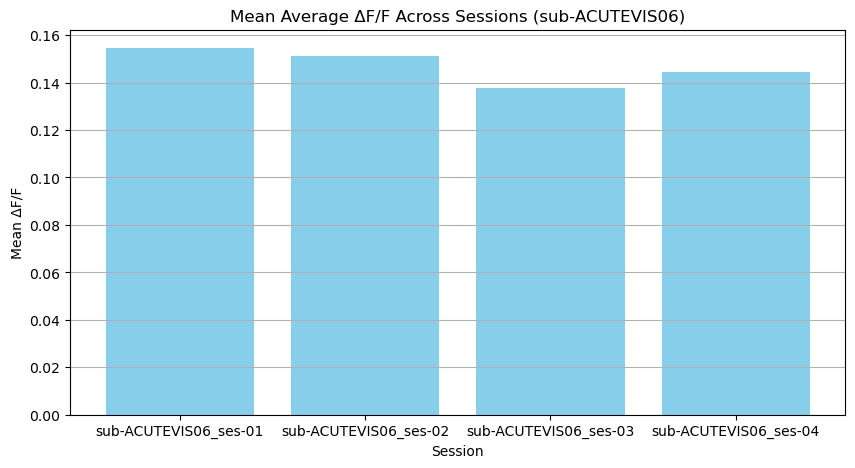

In [63]:
# Avg dff across sessions as a bar graph
plt.figure(figsize=(10, 5))
plt.bar(session_mean_dff.index, session_mean_dff.values, color='skyblue')
plt.title(f"Mean Average ΔF/F Across Sessions ({subject_label})")
plt.xlabel("Session")
plt.ylabel("Mean ΔF/F")
plt.grid(axis='y')
plt.show()

In [64]:
# DETECT PEAKS DURING EACH SESSION

def detect_roi_peaks(session_results, prominence=1.0, height=None, distance=None, width=None):
    """Run scipy.signal.find_peaks for every ROI in every session."""
    from scipy.signal import find_peaks
    peak_summary = {}
    peak_records = []
    optional_args = {}
    if height is not None:
        optional_args['height'] = height
    if distance is not None:
        optional_args['distance'] = distance
    if width is not None:
        optional_args['width'] = width
    for session_key, results in session_results.items():
        roi_traces = results['roi_dff']
        session_store = {}
        for roi_index, roi_trace in enumerate(roi_traces):
            roi_array = np.asarray(roi_trace, dtype=float).flatten()
            peaks, properties = find_peaks(roi_array, prominence=prominence, **optional_args)
            session_store[roi_index] = {'peaks': peaks, 'properties': properties}
            for peak_idx, frame_idx in enumerate(peaks):
                record = {
                    'session': session_key,
                    'roi_index': roi_index,
                    'peak_frame': int(frame_idx),
                    'peak_value': float(roi_array[frame_idx])
                }
                for prop_name, values in properties.items():
                    if isinstance(values, np.ndarray):
                        record[prop_name] = float(values[peak_idx])
                    else:
                        record[prop_name] = float(values)
                peak_records.append(record)
        peak_summary[session_key] = session_store
    peaks_df = pd.DataFrame(peak_records)
    return peak_summary, peaks_df

roi_peaks_by_session, roi_peak_df = detect_roi_peaks(session_results, prominence=0.7)
print(f"Peak DataFrame shape: {roi_peak_df.shape}")
roi_peak_df.head()

Peak DataFrame shape: (11112, 7)


,session,roi_index,peak_frame,peak_value,prominences,left_bases,right_bases
0,sub-ACUTEVIS06_ses-01,0,112,1.098099,0.795244,7.0,378.0
1,sub-ACUTEVIS06_ses-01,0,581,1.111996,1.162894,378.0,7190.0
2,sub-ACUTEVIS06_ses-01,0,765,0.849737,0.740380,724.0,848.0
3,sub-ACUTEVIS06_ses-01,0,1255,0.980779,0.968392,848.0,3586.0
4,sub-ACUTEVIS06_ses-01,0,1455,0.894948,0.976888,1353.0,2920.0


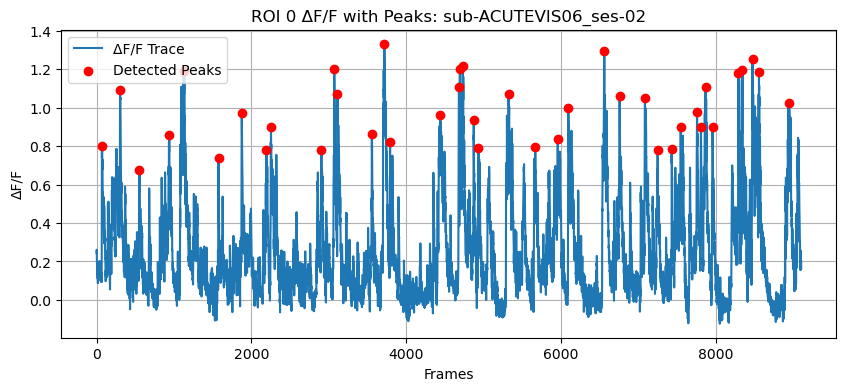

,session,roi_index,peak_frame,peak_value,prominences,left_bases,right_bases
2855,sub-ACUTEVIS06_ses-02,0,71,0.801666,0.715359,16.0,173.0
2856,sub-ACUTEVIS06_ses-02,0,303,1.094129,1.040369,173.0,771.0
2857,sub-ACUTEVIS06_ses-02,0,549,0.675502,0.724729,432.0,771.0
2858,sub-ACUTEVIS06_ses-02,0,938,0.858950,0.890666,771.0,1037.0
2859,sub-ACUTEVIS06_ses-02,0,1124,1.190152,1.241865,771.0,1528.0
2860,sub-ACUTEVIS06_ses-02,0,1574,0.740094,0.804398,1528.0,1753.0
2861,sub-ACUTEVIS06_ses-02,0,1874,0.974560,1.039778,1528.0,2369.0
2862,sub-ACUTEVIS06_ses-02,0,2193,0.778750,0.783071,2082.0,2238.0
2863,sub-ACUTEVIS06_ses-02,0,2252,0.899574,0.939326,2082.0,2369.0
2864,sub-ACUTEVIS06_ses-02,0,2903,0.780783,0.794809,2369.0,2962.0


In [65]:
# VERIFY PEAKS ON A SAMPLE ROI

preview_roi_index = selected_roi_index
if selected_session_key not in roi_peaks_by_session:
    raise KeyError(f"Session {selected_session_key} not present in roi_peaks_by_session.")
if preview_roi_index not in roi_peaks_by_session[selected_session_key]:
    raise KeyError(f"ROI {preview_roi_index} not present in roi_peaks_by_session[{selected_session_key}].")

roi_trace = np.asarray(selected_results['roi_dff'][preview_roi_index], dtype=float).flatten()
peak_info = roi_peaks_by_session[selected_session_key][preview_roi_index]
peak_indices = peak_info['peaks']

plt.figure(figsize=(10, 4))
plt.plot(roi_trace, label='ΔF/F Trace')
if peak_indices.size:
    plt.scatter(peak_indices, roi_trace[peak_indices], color='red', label='Detected Peaks', zorder=3)
plt.title(f'ROI {preview_roi_index} ΔF/F with Peaks: {selected_session_key}')
plt.xlabel('Frames')
plt.ylabel('ΔF/F')
plt.legend()
plt.grid()
plt.show()

roi_peak_df[(roi_peak_df['session'] == selected_session_key) & (roi_peak_df['roi_index'] == preview_roi_index)]

Average number of peaks per session (with SEM):
                       Average_Number_of_Peaks  SEM_Number_of_Peaks
session                                                            
sub-ACUTEVIS06_ses-01                11.797521             0.667774
sub-ACUTEVIS06_ses-02                11.629630             0.658953
sub-ACUTEVIS06_ses-03                11.237736             0.914357
sub-ACUTEVIS06_ses-04                10.306723             0.706600


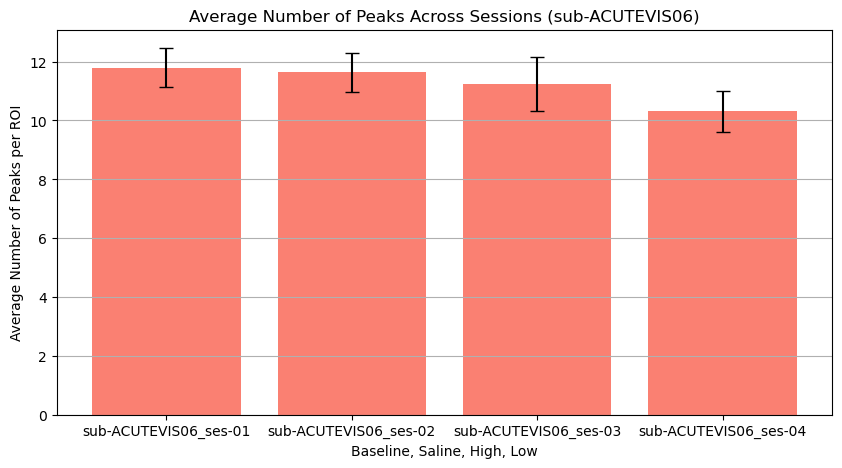

In [66]:
# AVG NUMBER OF PEAKS FOR ALL ROIS ACROSS SESSIONS
peaks_per_roi = (
    roi_peak_df.groupby(['session', 'roi_index'])
    .size()
    .reset_index(name='peak_count')
)
avg_num_peaks_by_session = peaks_per_roi.groupby('session')['peak_count'].mean()
sem_num_peaks_by_session = peaks_per_roi.groupby('session')['peak_count'].sem().fillna(0)
summary_df = pd.DataFrame({
    'Average_Number_of_Peaks': avg_num_peaks_by_session,
    'SEM_Number_of_Peaks': sem_num_peaks_by_session
})
print("Average number of peaks per session (with SEM):")
print(summary_df)

# PLOT AVG NUMBER OF PEAKS ACROSS SESSIONS
plt.figure(figsize=(10, 5))
plt.bar(
    avg_num_peaks_by_session.index,
    avg_num_peaks_by_session.values,
    yerr=sem_num_peaks_by_session.values,
    color='salmon',
    capsize=5
)
plt.title(f"Average Number of Peaks Across Sessions ({subject_label})")
plt.xlabel("Baseline, Saline, High, Low")
plt.ylabel("Average Number of Peaks per ROI")
plt.grid(axis='y')
plt.show()

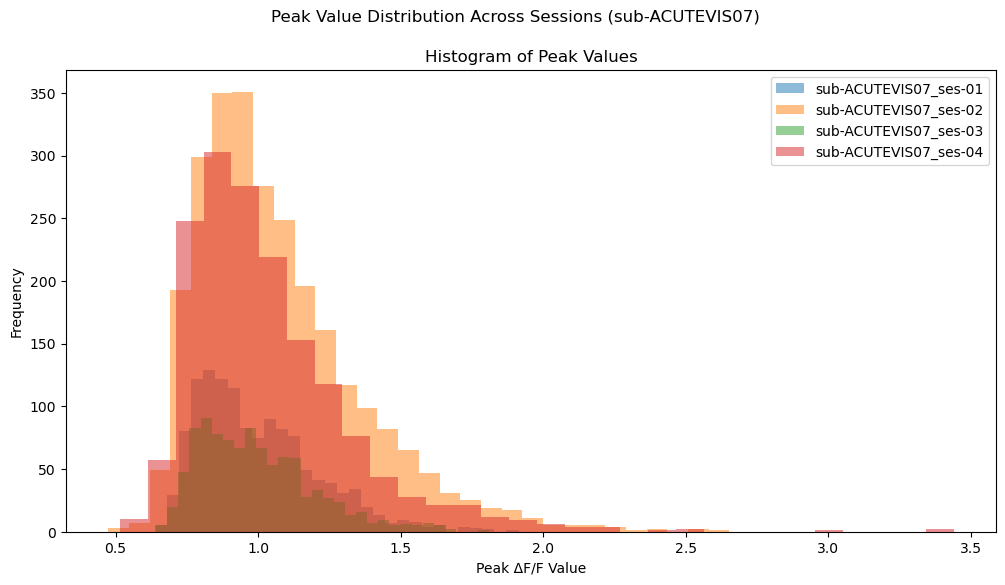

In [177]:
# PEAK FREQUENCY DISTRIBUTION ACROSS SESSIONS
plt.figure(figsize=(12, 6))
for session_key in average_dff_by_session.columns:
    session_peaks = roi_peak_df[roi_peak_df['session'] == session_key]
    plt.hist(session_peaks['peak_value'], bins=30, alpha=0.5, label=session_key)
plt.suptitle(f"Peak Value Distribution Across Sessions ({subject_label})")
plt.title("Histogram of Peak Values")
plt.xlabel("Peak ΔF/F Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


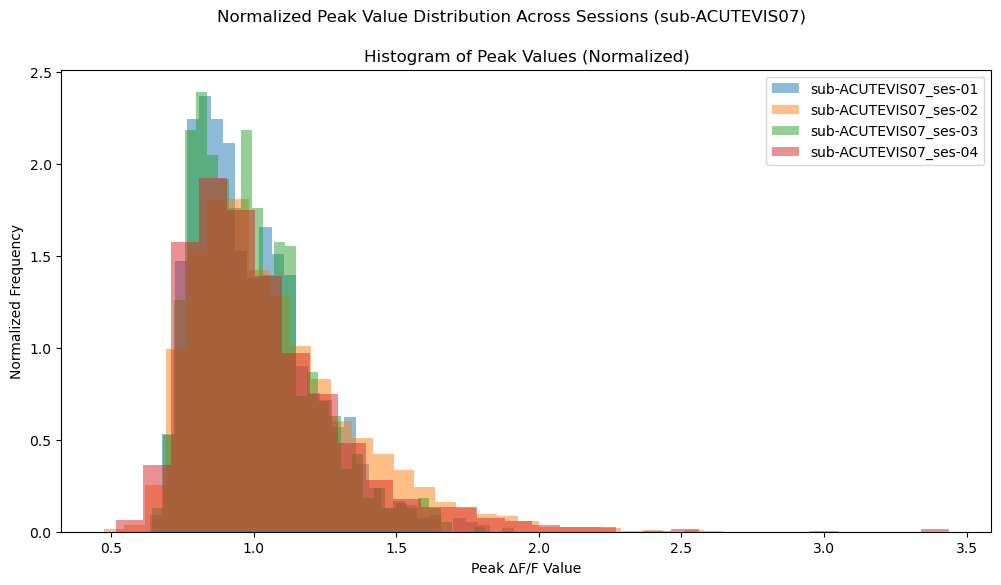

In [185]:
# NORMALIZED PEAK FREQUENCY DISTRIBUTION ACROSS SESSIONS
plt.figure(figsize=(12, 6))
for session_key in average_dff_by_session.columns:
    session_peaks = roi_peak_df[roi_peak_df['session'] == session_key]
    plt.hist(session_peaks['peak_value'], bins=30, density=True, alpha=0.5, label=session_key)  
    # density = True returns a probability density; each bin displays the bin's raw count divided by the total number of counts 
    # and the bin width (density = counts / (sum(counts) * np.diff(bins))), so the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1)
plt.suptitle(f"Normalized Peak Value Distribution Across Sessions ({subject_label})")
plt.title("Histogram of Peak Values (Normalized)")          
plt.xlabel("Peak ΔF/F Value")
plt.ylabel("Normalized Frequency")
plt.legend()